In [90]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account

# from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report


# Reference
https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [91]:
print(tf.__version__)

2.12.0


In [114]:
#table_id='test_incident'
# table_id='validation_incident'
#table_id='new_incident'
table_id='train_incident'

ENDPOINT_ID="2469916532356939776"
MODEL_ID="2354195132556771328"

isLocalModel=False
isBQToCSV=True
localMapFile=True
gs_store_class="demo2-tf-incident-pongthorn"
gs_model_path="gs://demo2-tf-incident-pongthorn/demo_model_tf"

modelFile_endPoint=2
#1=local(dev)/gcs(clound function) and 2=endpoint on vertext

# projectId='smart-data-ml'
projectId='pongthorn'
dataset_id='SMartML'
REGION="asia-southeast1"

n_sample_run=0

# mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
bqclient= bigquery.Client(project=projectId)

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='csv_dataset/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'csv_dataset/Prediction_{table_id}.csv'


In [115]:
if isBQToCSV:
    
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    
  
if n_sample_run>0:
 dfNewData=dfNewData.tail(n_sample_run)
print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2731 non-null   Int64  
 1   severity_name              2731 non-null   object 
 2   sla                        2731 non-null   object 
 3   product_type               2731 non-null   object 
 4   brand                      2731 non-null   object 
 5   service_type               2731 non-null   object 
 6   incident_type              2731 non-null   object 
 7   open_to_close_hour         2731 non-null   float64
 8   response_to_resolved_hour  2731 non-null   float64
 9   label_multi_severity       2731 non-null   Int64  
 10  label_binary_severity      2731 non-null   Int64  
dtypes: Int64(3), float64(2), object(6)
memory usage: 242.8+ KB
None



# Load and Map Data Test

In [116]:

mapping_file="incident_severity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket(gs_store_class)
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localMapFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)



{'Cosmetic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [117]:
if  table_id=='new_incident':
   dfNewData['severity']= dfNewData['severity_name'].map(map_sevirity_to_class)
else:
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_binary_severity'])

if 'id' not in dfNewData.columns.to_list():
    dfNewData=dfNewData.reset_index(drop=True)
    dfNewData = dfNewData.reset_index(level=0)
    dfNewData.rename(columns={"index": "id"},inplace=True)
    dfNewData['id']=dfNewData['id']+1
print(f"Table: {table_id}")
print(filePath) 
print(dfNewData.info())
dfNewData.sample(n_sample_run)

Table: train_incident
csv_dataset/Prediction_validation_incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         2731 non-null   int64  
 1   severity_id                2731 non-null   Int64  
 2   severity_name              2731 non-null   object 
 3   sla                        2731 non-null   object 
 4   product_type               2731 non-null   object 
 5   brand                      2731 non-null   object 
 6   service_type               2731 non-null   object 
 7   incident_type              2731 non-null   object 
 8   open_to_close_hour         2731 non-null   float64
 9   response_to_resolved_hour  2731 non-null   float64
 10  severity                   2731 non-null   Int64  
dtypes: Int64(2), float64(2), int64(1), object(6)
memory usage: 240.2+ KB
None


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity


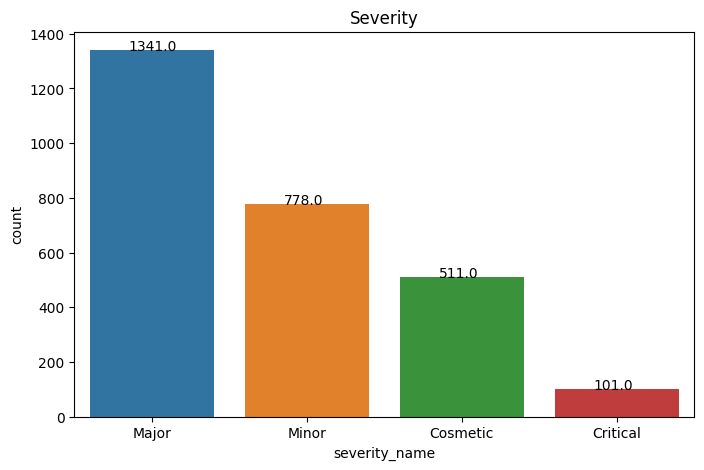

In [118]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

# Classification Rerport

In [119]:
def make_classification_report(dfResult):
    print(dfResult.tail())
    className=list(set().union(list(dfResult['severity'].unique()),list(dfResult['_predict_severity'].unique())))
    actualClass=[  f'actual-{x}' for x in  className]
    predictedlClass=[  f'predcited-{x}' for x in className]

    y_true=list(dfResult['severity'])
    y_pred=list(dfResult['_predict_severity'])
    cnf_matrix = confusion_matrix(y_true,y_pred)

    # #index=actual , column=prediction
    cm_df = pd.DataFrame(cnf_matrix,
                         index = actualClass, 
                         columns = predictedlClass)
    print(cm_df)

    print(classification_report(y_true, y_pred, labels=className))

# Load Model from Directory to Predict

In [120]:
if  isLocalModel: # Window Enviroment
    PATH_FOLDER_ARTIFACTS="model"    
else: # For running on Vertex AI Notebook t
    PATH_FOLDER_ARTIFACTS=gs_model_path
print(f"Load from {PATH_FOLDER_ARTIFACTS}")
model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)   
print(model.tensorflow_version)

Load from gs://demo2-tf-incident-pongthorn/demo_model_tf
2.12.0


# Prediction by model on entire rows at once

In [121]:
if modelFile_endPoint==1 :
    pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
    pdPrediction

    # print(model.summary())

    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          # print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
        
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          print(row_dict)  

          input_tensor = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}
          predictionResult = model.predict(input_tensor)

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          
          # print(input_tensor)    
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]
    print("Predicted all data completely")


# Registry and Deploy Model to VertextAI
- https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#deploy_a_model_to_an_endpoint


## Load Model from Online EndPpint to Predict
- https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/train-and-deploy-model
- https://cloud.google.com/vertex-ai/docs/tutorials/tabular-bq-prediction/make-prediction

In [122]:
from google.cloud import aiplatform


# Load model from Vertext-Ai Model Registry

In [123]:
#https://console.cloud.google.com/vertex-ai/endpoints?project=pongthorn
#https://console.cloud.google.com/vertex-ai/batch-predictions?project=pongthorn

MODEL_URI =  f'projects/{projectId}/locations/{REGION}/models/{MODEL_ID}'
print(MODEL_URI)

model_reg = aiplatform.Model(MODEL_URI)

model_name=model_reg.display_name
print(model_reg.uri," - ",model_name)

projects/pongthorn/locations/asia-southeast1/models/2354195132556771328
gs://demo2-tf-incident-pongthorn/demo_model_tf  -  model-incident-tf-explainable


# Make a call to Endpoint

In [124]:
isEndpointAvaiable=False

listRequestData=[]
try:
    
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}")
                                   
    # endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
    #                                ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))

resource name: projects/780371717407/locations/asia-southeast1/endpoints/2469916532356939776


# Create Instances and feed it to endpoint to predict

# Convert to tenfor format

In [125]:
dfID=dfNewData[['id']]
dfID.reset_index(inplace=True,drop=True)
dfY=dfNewData[['severity','severity_name']]
dfY.reset_index(inplace=True,drop=True)
dfX=dfNewData.drop(columns=unUsedColtoPredict)
dfX.reset_index(inplace=True,drop=True)

In [126]:
instances = []
for index,row in dfX.iterrows():
    dict_item=row.to_dict()
    instance = {}
    for key, value in dict_item.items():
        if key in unUsedColtoPredict:
            continue
        if value is None:
            value = ""
        instance[key] = [value]
        # instance[key] = value
    instances.append(instance)

print(len(instances))
print(instances[0])

2731
{'sla': ['24x7 4Hrs Resolution Time'], 'product_type': ['Other'], 'brand': ['F5'], 'service_type': ['Incident'], 'incident_type': ['General Incident'], 'open_to_close_hour': [1928.1333333333334], 'response_to_resolved_hour': [1927.6333333333334]}


# Prediction by endpoint on entire rows at once

In [127]:
predictions = endpoint.predict(instances=instances)
predictedY = np.argmax(predictions.predictions, axis=1)

dfPredictedY=pd.DataFrame(data={'_predict_severity':predictedY})

In [128]:
dfOnlinePred=pd.concat([dfID,dfPredictedY,dfY],axis=1)
dfOnlinePred.tail()

,id,_predict_severity,severity,severity_name
2726,2727,0,0,Cosmetic
2727,2728,0,0,Cosmetic
2728,2729,0,0,Cosmetic
2729,2730,0,0,Cosmetic
2730,2731,0,0,Cosmetic


In [130]:
make_classification_report(dfOnlinePred)

        id  _predict_severity  severity severity_name
2726  2727                  0         0      Cosmetic
2727  2728                  0         0      Cosmetic
2728  2729                  0         0      Cosmetic
2729  2730                  0         0      Cosmetic
2730  2731                  0         0      Cosmetic
          predcited-0  predcited-1  predcited-2  predcited-3
actual-0          426           34           51            0
actual-1           72          470          236            0
actual-2           38          204         1099            0
actual-3            0           12           88            1
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       511
           1       0.65      0.60      0.63       778
           2       0.75      0.82      0.78      1341
           3       1.00      0.01      0.02       101

    accuracy                           0.73      2731
   macro avg       0.80      0.57      0.56  

# Get explanations

In [131]:
input_name = model.input_names
print("Model input name:", input_name)
output_name = model.output_names
print("Model output name:", output_name)

Model input name: ['open_to_close_hour', 'response_to_resolved_hour', 'sla', 'product_type', 'brand', 'service_type', 'incident_type']
Model output name: ['dense_1']


In [132]:
# https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions#interpret_explanation_results
# https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-online-predictions#example_output_for_predictions_and_explanations
# https://cloud.google.com/vertex-ai/docs/tabular-data/classification-explanations


listExplainModel=[]
def explain_model( instanceList):

    response = endpoint.explain(instances=instanceList, parameters={})

    for explanation in response.explanations:
        # print("Explanation")
        # Feature attributions.
        attributions = explanation.attributions
        item={}
        for attribution in attributions:
            item["baseline_output"]=attribution.baseline_output_value
            item["instance_output"]=attribution.instance_output_value
            item["approx_error"]=attribution.approximation_error
            item["baseline_output"]=attribution.baseline_output_value
            sum_feat=0;
            for name in input_name:
              feat_value= attribution.feature_attributions[name][0]
              sum_feat=sum_feat+feat_value
              # print(f"  {name} :{feat_value}")
              item[name]=feat_value
            # print(f"  The sum of all of the feature importance values(instance-baseline) = {sum_feat}")
            item["sum_feat_imp"]=sum_feat
        listExplainModel.append(item)   
        

explain_model(instances)

In [133]:
dfExplainModelResult=pd.DataFrame(data=listExplainModel)
dfExplainModelResult

,baseline_output,instance_output,approx_error,open_to_close_hour,response_to_resolved_hour,sla,product_type,brand,service_type,incident_type,sum_feat_imp
0,0.455226,0.548201,0.000477,-0.019846,0.164745,0.013913,-0.178224,-0.083402,0.196366,-0.000577,0.092975
1,0.181268,0.637492,0.000213,-0.031823,0.028194,-0.116349,0.098719,0.005888,0.464640,0.006954,0.456224
2,0.289242,0.535007,0.000523,-0.005488,-0.001933,0.025289,0.128846,0.113438,-0.052627,0.038240,0.245765
3,0.289242,0.493757,0.000326,0.025946,-0.019992,0.077770,0.119438,0.142340,-0.050398,-0.090589,0.204515
4,0.289242,0.584111,0.000439,0.069293,-0.042596,0.027856,0.132412,0.121799,-0.042076,0.028181,0.294869
...,...,...,...,...,...,...,...,...,...,...,...
2726,0.181268,0.755050,0.000176,-0.000085,0.000051,-0.043476,0.010866,0.059169,0.510651,0.036605,0.573782
2727,0.181268,0.808556,0.000222,-0.000163,0.000151,0.021428,-0.033273,0.059140,0.549570,0.030434,0.627288
2728,0.181268,0.706211,0.000179,-0.003764,0.003196,-0.050832,-0.002227,0.060690,0.505430,0.012450,0.524943
2729,0.181268,0.719601,0.000195,-0.001514,0.001509,-0.038786,-0.042472,0.055041,0.525324,0.039231,0.538333


In [135]:
dfABC=dfExplainModelResult[input_name].sum().to_frame().T
dfABC['dataset']=table_id
dfABC=dfABC.set_index('dataset')
dfABC

,open_to_close_hour,response_to_resolved_hour,sla,product_type,brand,service_type,incident_type
dataset,,,,,,,
train_incident,-6.573598,9.680649,46.064534,202.722242,126.676031,421.883258,167.885094


In [136]:
writer = pd.ExcelWriter(f'{table_id}_{model_name}_exp.xlsx')
for i, dataframe in enumerate([dfExplainModelResult,dfABC]):
    dataframe.to_excel(writer, sheet_name=f'Sheet{i + 1}')
writer.save()

/var/tmp/ipykernel_62661/1769812406.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# Prediction individual row

In [113]:
# if modelFile_endPoint==2 and isEndpointAvaiable==True :

#     for data in dfNewData.to_dict(orient="records"):
#         incident_id=data['id']
#         severity=data['severity']
#         severity_name=data['severity_name']
#         # convert dict to tf format
#         request_data = {key : [value] for key,value in data.items() }
#         for key_removed in unUsedColtoPredict:
#            request_data.pop(key_removed)
#         listRequestData.append(request_data)
#         print(request_data)

#         response = endpoint.predict([request_data])
#         y_predicted = np.argmax(response.predictions, axis=1)
#         predictionResult=response[0][0]
#         print(predictionResult)
#         print(y_predicted)

#         pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
#         print("======================================================================================")

#     dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
#     dfPredictData=dfPredictData.drop(columns=['_id'])
#     dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
# else:
#      print("No endpoint to predict  as online predction")     